In [2]:
import matplotlib.pyplot as plt
import collections

In [51]:
gps_data = {
    'latitude': [],
    'longitude': [],
    'speed': [],
    'altitude': [],
    'numSats': []
}
imu_data = {
    'timeMillis': [],
    'xAccel': [],
    'yAccel': [],
    'zAccel': [],
    'xGyro': [],
    'yGyro': [],
    'zGyro': [],
    'xMag': [],
    'yMag': [],
    'zMag': [],
    'temp': []
}

num_adcs = 1016
uwb_data = {
    'real' : [ [] for i in range(num_adcs) ],
    'imaginary' : [ [] for i in range(num_adcs) ]
}

In [52]:
# for now, make sure the imu data is strictly increasing to capture data for one trial
prev_time = 0

with open('uwb-output.txt', 'r') as file:
    for line in file:
        if line.startswith('GPS'):
            _, lat, lon, speed, altitude, numSats = line[5:].split(',')
            gps_data['latitude'].append(float(lat))
            gps_data['longitude'].append(float(lon))
            gps_data['speed'].append(float(speed))
            gps_data['altitude'].append(float(altitude))
            gps_data['numSats'].append(int(numSats))
        elif line.startswith('CIR'):
            #this is the "UWB Accumulator" register with waveform data
            line = line.split(' ')
            acc_mem = line[3] #CIR num1 num2 acc_mem
            acc_mem = acc_mem.split('],[')
            #remove extra brackets
            acc_mem[0] = acc_mem[0][1:]
            acc_mem[-1] = acc_mem[-1][:-3] #lines end in '...,]\n' so remove the last 3 chars

            #ensure good data
            assert len(acc_mem) == num_adcs

            #split into real and imaginary parts
            for i in range(num_adcs):
                memVals = acc_mem[i].split(',')
                if len(memVals) != 4:
                    continue #bad data
                
                value, real, imaginary, adc = acc_mem[i].split(',')
                uwb_data['real'][i].append(int(real))
                uwb_data['imaginary'][i].append(int(imaginary))
        else: # line.startswith('UWB') and not line.startswith('.'):
            time, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro, x_mag, y_mag, z_mag, temp = line.split(',')
            if int(time) < prev_time:
                valid = False
                continue
            imu_data['timeMillis'].append(int(time))
            imu_data['xAccel'].append(float(x_accel))
            imu_data['yAccel'].append(float(y_accel))
            imu_data['zAccel'].append(float(z_accel))
            imu_data['xGyro'].append(float(x_gyro))
            imu_data['yGyro'].append(float(y_gyro))
            imu_data['zGyro'].append(float(z_gyro))
            imu_data['xMag'].append(float(x_mag))
            imu_data['yMag'].append(float(y_mag))
            imu_data['zMag'].append(float(z_mag))
            imu_data['temp'].append(float(temp))
            prev_time = int(time)
            

num_sats_counts = collections.Counter(gps_data['numSats'])
num_sats_values = list(num_sats_counts.keys())
num_sats_count = list(num_sats_counts.values())        

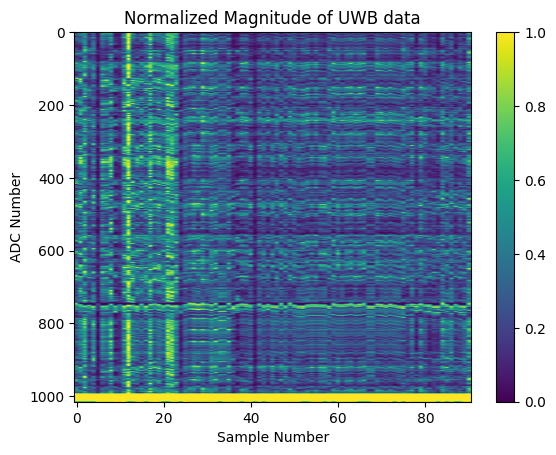

In [67]:
#show a spectrogram of the UWB data

#convert to numpy arrays
import numpy as np
real = np.array(uwb_data['real'], dtype=np.float64)
imaginary = np.array(uwb_data['imaginary'], dtype=np.float64)

#convert to complex numbers
complex_data = real + imaginary*1j

#compute the magnitude
magnitude = np.abs(complex_data)

normalize = True
if normalize:
    for i in range(num_adcs): #Normalize data for each ADC
        magnitude[i,:] = magnitude[i,:] / np.max(magnitude[i,:])

#compute the phase
phase = np.angle(complex_data)

#plot the magnitude
plt.figure()
plt.imshow(magnitude, aspect='auto')
plt.colorbar()
plt.title('Normalized Magnitude of UWB data')
plt.xlabel('Sample Number')
plt.ylabel('ADC Number')
plt.show()

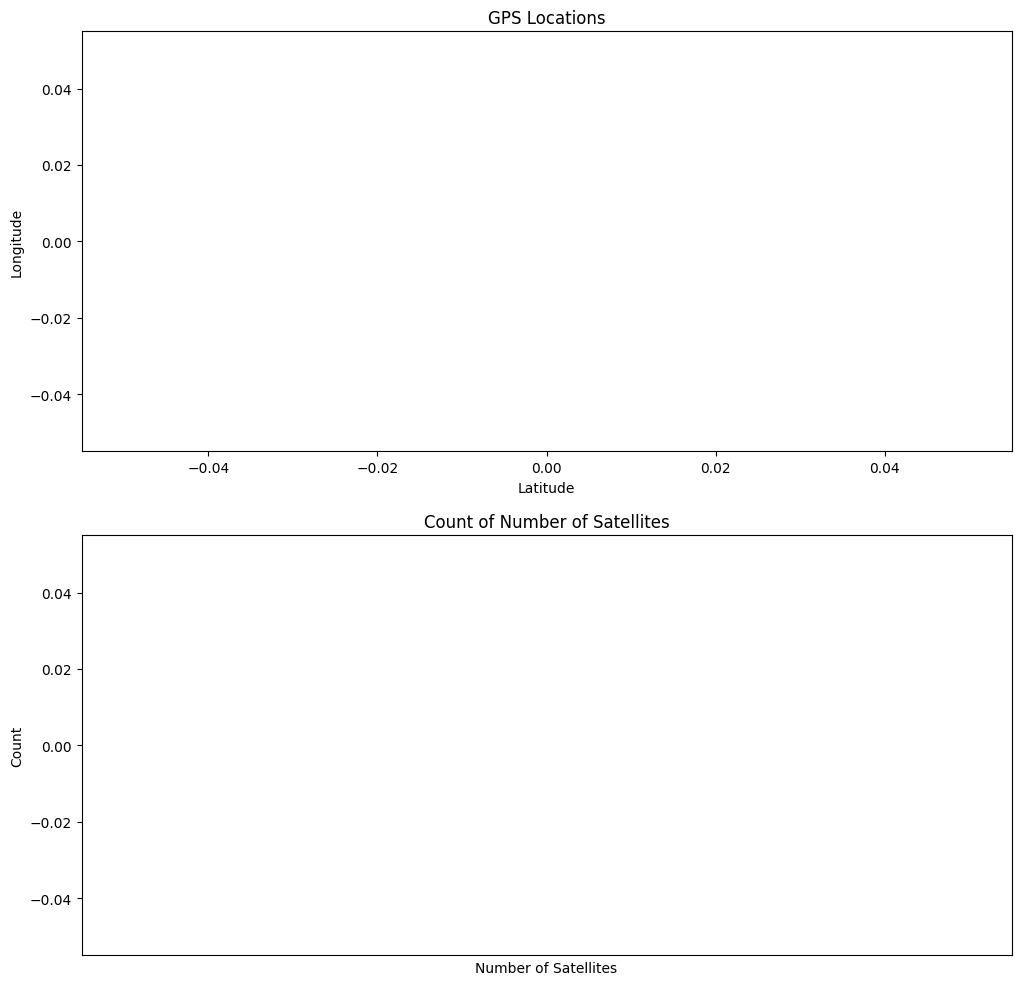

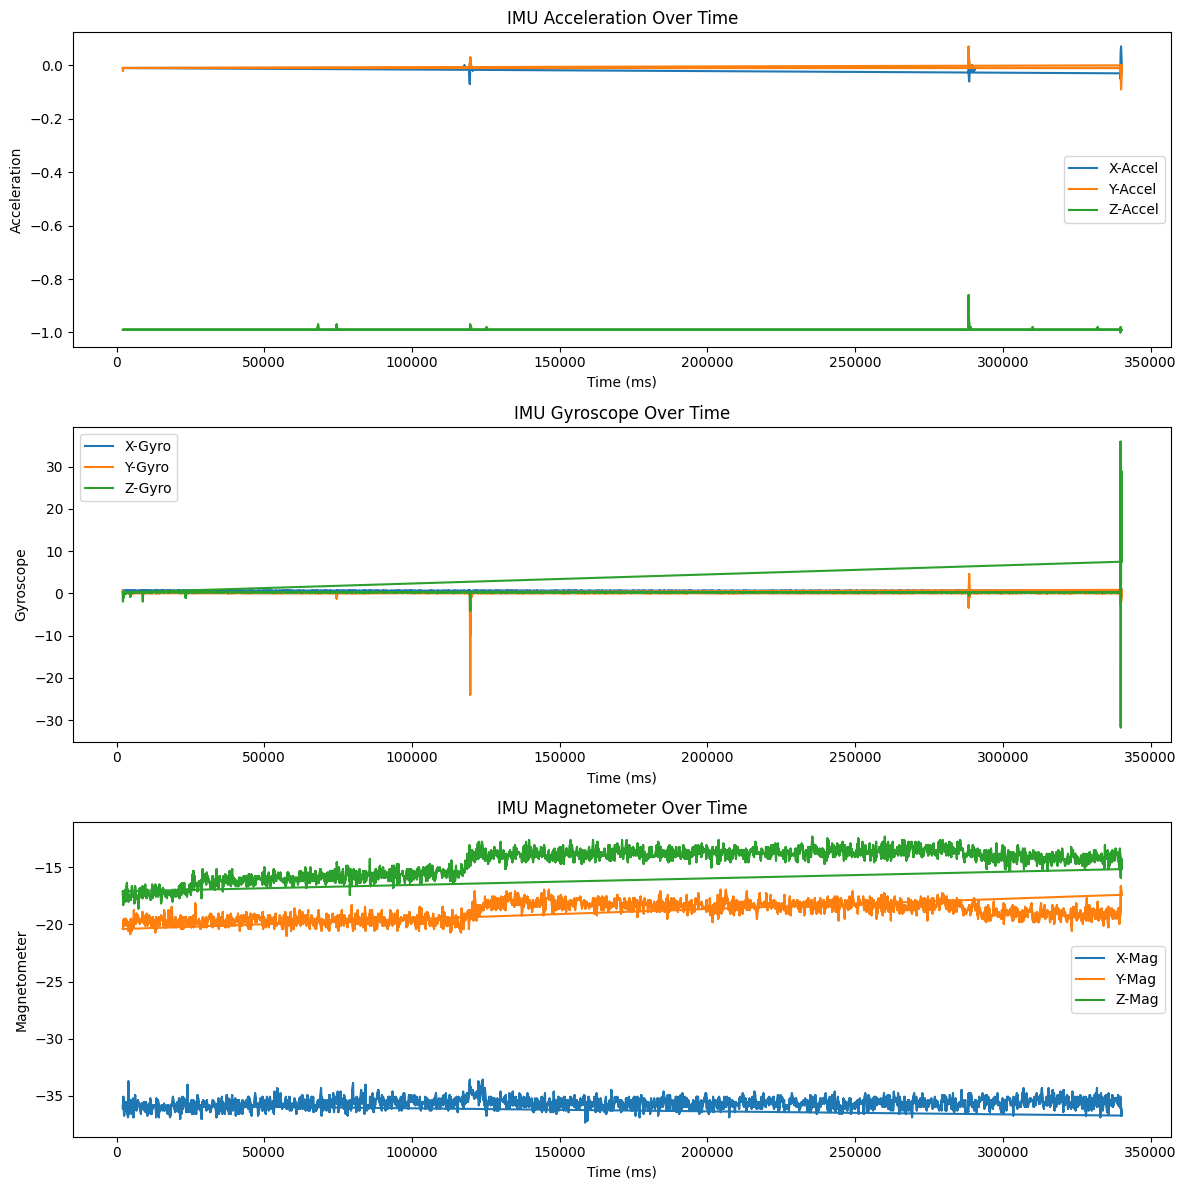

In [14]:
plt.figure(figsize=(12, 12))

# Latitude vs Longitude
plt.subplot(2, 1, 1)
plt.scatter(gps_data['latitude'], gps_data['longitude'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('GPS Locations')

# Number of Satellites vs Count
plt.subplot(2, 1, 2)
plt.bar(num_sats_values, num_sats_count)
plt.xlabel('Number of Satellites')
plt.ylabel('Count')
plt.title('Count of Number of Satellites')
plt.xticks(num_sats_values)
plt.show()

plt.figure(figsize=(12, 12))

# Acceleration over Time
plt.subplot(3, 1, 1)
plt.plot(imu_data['timeMillis'], imu_data['xAccel'], label='X-Accel')
plt.plot(imu_data['timeMillis'], imu_data['yAccel'], label='Y-Accel')
plt.plot(imu_data['timeMillis'], imu_data['zAccel'], label='Z-Accel')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration')
plt.title('IMU Acceleration Over Time')
plt.legend()

# Gyroscope over Time
plt.subplot(3, 1, 2)
plt.plot(imu_data['timeMillis'], imu_data['xGyro'], label='X-Gyro')
plt.plot(imu_data['timeMillis'], imu_data['yGyro'], label='Y-Gyro')
plt.plot(imu_data['timeMillis'], imu_data['zGyro'], label='Z-Gyro')
plt.xlabel('Time (ms)')
plt.ylabel('Gyroscope')
plt.title('IMU Gyroscope Over Time')
plt.legend()

# Magnetometer over Time
plt.subplot(3, 1, 3)
plt.plot(imu_data['timeMillis'], imu_data['xMag'], label='X-Mag')
plt.plot(imu_data['timeMillis'], imu_data['yMag'], label='Y-Mag')
plt.plot(imu_data['timeMillis'], imu_data['zMag'], label='Z-Mag')
plt.xlabel('Time (ms)')
plt.ylabel('Magnetometer')
plt.title('IMU Magnetometer Over Time')
plt.legend()

plt.tight_layout()
plt.show()